# GenMedia with ADK

Last Update:

- June 8, 2025
- ADK == 1.1.1

The notebook includes GenMedia related ADK samples:
- Call Imagen end points for image generation
- Use artifacts to save/ load bytes
- Display image in CoLab environment

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.sandbox.google.com/github/hupili/google-adk-101/blob/main/GenMedia.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2Fhupili%2Fgoogle-adk-101%2Fmain%2FGenMedia.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-enterprise-logo.png" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://github.com/hupili/google-adk-101/blob/main/GenMedia.ipynb">
      <img width="32px" src="https://www.gstatic.com/monospace/240802/git_host_github_mask.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/hupili/google-adk-101/main/GenMedia.ipynb">
      <img width="32px" src="https://www.gstatic.com/cloud/images/navigation/vertex-ai.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>

## Environment Setup

In [ ]:
import os

# API_KEY = '' # @param {type:"string"}
# os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "FALSE" # Use Vertex AI API
# os.environ["GOOGLE_API_KEY"] = API_KEY

PROJECT_ID = "hupili-genai-bb"  # @param {type:"string"}
if not PROJECT_ID:
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = "us-central1" # @param {type:"string"}

STAGING_BUCKET = 'gs://agent_engine_deploy_staging' # @param {type:"string"}

os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
os.environ["GOOGLE_CLOUD_LOCATION"] = LOCATION
os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "TRUE" # Use Vertex AI API
ARTIFACTS_BUCKET = 'hupili-genai-bb-public' # @param {type:"string"}

# [your-project-id]

In [ ]:
import vertexai

vertexai.init(
    project=PROJECT_ID,
    location=LOCATION,
    staging_bucket=STAGING_BUCKET,
)

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!pip install deprecated
!pip install google-adk==1.1.1

In [ ]:
from google import adk

In [ ]:
import json
import time

def pprint_events(events):
    '''Pretty print of events generated by ADK runner'''
    start_time = time.time()
    for _, event in enumerate(events):
        is_final_response = event.is_final_response()
        function_calls = event.get_function_calls()
        function_responses = event.get_function_responses()
        agent_res = json.loads(event.content.model_dump_json(indent=2, exclude_none=True))

        if is_final_response:
            print('>>> inside final response...')
            final_response = event.content.parts[0].text
            end_time = time.time()
            elapsed_time_ms = round((end_time - start_time) * 1000, 3)
            print(f'Final Response ({elapsed_time_ms} ms):\n{final_response}')
            print("-----------------------------")
        elif function_calls:
            print('+++ inside the function call...')
            for function_call in function_calls:
                print(f"function, [args]:  {function_call.name}, {function_call.args}")
        elif function_responses:
            print('--- inside the function call response...')
            # TODO(Pili): copied from walkthrough codes. Find root cause of 'pending' not found.
            # if not event.actions.pending:
            if True:
                for function_response in function_responses:
                    details = function_response.response
                    recommended_list = list(details.values())
                    print(f"Function Name: {function_response.name}")
                    result=json.dumps(recommended_list)
                    print(f"Function Results {result}")
            else:
                print(agent_res)
    print(f"Total elapsed time: {elapsed_time_ms}")


In [ ]:
import random
import asyncio

from google.adk.tools import google_search
from google.adk import Agent
from google.adk.agents import Agent, LlmAgent
from google.genai import types
from pydantic import BaseModel
from google.genai import types
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner

async def caller_factory(root_agent, app_name='App12345', user_id='User12345', session_id=None):
  session_service = InMemorySessionService()
  if session_id is None:
    suffix = random.randint(100000, 999999)
    session_id = f'{app_name}-{user_id}-{suffix}'
  session = await session_service.create_session(
      app_name=app_name, user_id=user_id, session_id=session_id)
  runner = Runner(agent=root_agent, app_name=app_name, session_service=session_service)
  def _call(query):
    content = types.Content(role='user', parts=[types.Part(text=query)])
    events = runner.run(user_id=session.user_id, session_id=session.id, new_message=content)
    return events
  return _call

In [ ]:
MODEL = "gemini-2.0-flash"
APP_NAME = "simple_search_example"
USER_ID = "user12345"
SESSION_ID = "session12345"
AGENT_NAME = "simple_search_agent"

# Agent
simple_search_agent = Agent(
    model=MODEL,
    name="simple_search_agent",
    description="Agent to answer questions using Google Search.",
    instruction="I can answer your questions by searching the internet. Just ask me anything!",
    generate_content_config=types.GenerateContentConfig(
        max_output_tokens=8000,
    ),
    tools=[google_search],
)

In [ ]:
call_agent = await caller_factory(simple_search_agent)

In [ ]:
events = call_agent('Hello')

In [ ]:
pprint_events(events)

>>> inside final response...
Final Response (1111.696 ms):
Hello! How can I help you today?

-----------------------------
Total elapsed time: 1111.696


In [ ]:
events = call_agent('What is the weather in Hong Kong now?')
pprint_events(events)

>>> inside final response...
Final Response (2245.137 ms):
The weather in Hong Kong is partly cloudy with a temperature of 89°F (32°C), but it feels like 99°F (37°C) due to the humidity of around 64%. There is a 0% chance of rain. The forecast for today is mostly cloudy during the day and cloudy at night.

-----------------------------
Total elapsed time: 2245.137


## Call Imagen

In [ ]:
import typing
import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps

def display_image(
    image,
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    pil_image = typing.cast(PIL_Image.Image, image._pil_image)
    if pil_image.mode != "RGB":
        # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
        pil_image = pil_image.convert("RGB")
    image_width, image_height = pil_image.size
    if max_width < image_width or max_height < image_height:
        # Resize to display a smaller notebook image
        pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
    IPython.display.display(pil_image)

In [ ]:
from vertexai.preview.vision_models import ImageGenerationModel
import vertexai

def imagen_generate(prompt: str, model: str ="imagen-4.0-generate-preview-05-20"):
  generation_model = ImageGenerationModel.from_pretrained(model)

  images = generation_model.generate_images(
      prompt=prompt,
      number_of_images=4,
      aspect_ratio="1:1",
      negative_prompt="",
      person_generation="allow_adult",
      safety_filter_level="block_few",
      add_watermark=True,
  )

  return images

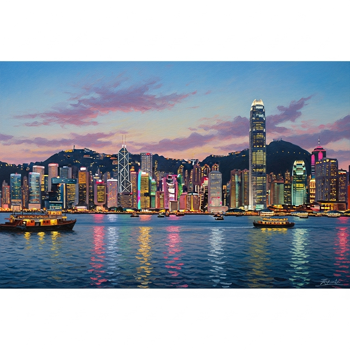

In [ ]:
images = imagen_generate("oil paint of Hong Kong landscape")
display_image(images[0])

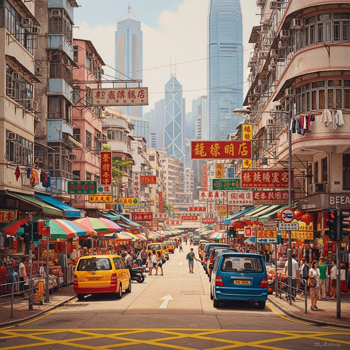

In [ ]:
display_image(images[1])

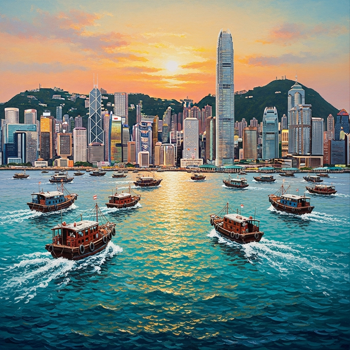

In [ ]:
display_image(images[2])

## Gemini Enhanced Imagen (multi-turn)

In [ ]:
from google.adk.artifacts import GcsArtifactService

# Specify the GCS bucket name
gcs_bucket_name_py = ARTIFACTS_BUCKET # Replace with your bucket name

try:
    gcs_service_py = GcsArtifactService(bucket_name=gcs_bucket_name_py)
    print(f"Python GcsArtifactService initialized for bucket: {gcs_bucket_name_py}")
    # Ensure your environment has credentials to access this bucket.
    # e.g., via Application Default Credentials (ADC)

    # Then pass it to the Runner
    # runner = Runner(..., artifact_service=gcs_service_py)

except Exception as e:
    # Catch potential errors during GCS client initialization (e.g., auth issues)
    print(f"Error initializing Python GcsArtifactService: {e}")
    # Handle the error appropriately - maybe fall back to InMemory or raise

async def caller_factory(root_agent, app_name='GenMedia', user_id='User12345', session_id=None):
  session_service = InMemorySessionService()
  if session_id is None:
    suffix = random.randint(100000, 999999)
    session_id = f'{app_name}-{user_id}-{suffix}'
  session = await session_service.create_session(
      app_name=app_name, user_id=user_id, session_id=session_id)
  runner = Runner(agent=root_agent, app_name=app_name, session_service=session_service, artifact_service=gcs_service_py)
  def _call(query):
    content = types.Content(role='user', parts=[types.Part(text=query)])
    events = runner.run(user_id=session.user_id, session_id=session.id, new_message=content)
    return events
  return _call

Python GcsArtifactService initialized for bucket: hupili-genai-bb-public


In [ ]:
from google.adk.tools.tool_context import ToolContext
import google.genai.types as types
from google.adk.agents.callback_context import CallbackContext # Or ToolContext
import base64
from google.cloud import storage
import mimetypes # Import mimetypes

async def save_image_file(
    filename: str, file_bytes: bytes, mime_type: str, tool_context: ToolContext
) -> str:
    """Save a text file to artifacts service.
    """
    try:
        # file_bytes = file_text.encode('utf-8')
        artifact = types.Part(inline_data=types.Blob(data=file_bytes, mime_type=mime_type))
        # Pass only the filename to save_artifact
        await tool_context.save_artifact(filename=filename, artifact=artifact)
        return filename
    except Exception as e:
        print(f"Error saving file {e}")
        return ""

async def list_files(tool_context: ToolContext) -> str:
    """Tool to list available artifacts for the user."""
    try:
        available_files = await tool_context.list_artifacts()
        if not available_files:
            return "You have no saved artifacts."
        else:
            # Format the list for the user/LLM
            file_list_str = "\n".join([f"- {fname}" for fname in available_files])
            return f"Here are your available Python artifacts:\n{file_list_str}"
    except ValueError as e:
        print(f"Error listing Python artifacts: {e}. Is ArtifactService configured?")
        return "Error: Could not list Python artifacts."
    except Exception as e:
        print(f"An unexpected error occurred during Python artifact list: {e}")
        return "Error: An unexpected error occurred while listing Python artifacts."

def display_image_colab(
    image_bytes,
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    from io import BytesIO
    pil_image = PIL_Image.open(BytesIO(image_bytes))
    if pil_image.mode != "RGB":
        # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
        pil_image = pil_image.convert("RGB")
    image_width, image_height = pil_image.size
    if max_width < image_width or max_height < image_height:
        # Resize to display a smaller notebook image
        pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
    IPython.display.display(pil_image)

async def display_image_file(
    filename: str, tool_context: ToolContext
) -> str:
    """Load a image file from artifacts service and display it.
    """
    try:
        artifact = await tool_context.load_artifact(filename=filename)
        file_bytes = artifact.inline_data.data
        display_image_colab(file_bytes)
        return "Success"
    except Exception as e:
        print(f"Error loading file {e}")
        return "Error"

In [ ]:
# prompt: convert images[0] to png format and return bytes

def convert_to_png_bytes(image):
  """Converts a PIL Image object to PNG format bytes."""
  from io import BytesIO
  img_byte_arr = BytesIO()
  pil_image = typing.cast(PIL_Image.Image, image._pil_image)
  if pil_image.mode != "RGB":
    pil_image = pil_image.convert("RGB")
  pil_image.save(img_byte_arr, format='PNG')
  return img_byte_arr.getvalue()

# png_bytes = convert_to_png_bytes(images[0])
# print(f"Converted image[0] to PNG format with {len(png_bytes)} bytes.")

In [ ]:
from vertexai.preview.vision_models import ImageGenerationModel
import vertexai

async def imagen_generate(prompt: str, slug: str,
                          tool_context: ToolContext,
                          model: str ="imagen-4.0-generate-preview-05-20",
                          )->dict:
  '''Call imagen model to generate images based on the prompt.

  Returns a dict
  {
    'prompt': prompt,
    'slug': slug,
    'files': [slug-1.png, slug-2.png, slug-3.png, ...]
  }
  '''
  generation_model = ImageGenerationModel.from_pretrained(model)

  images = generation_model.generate_images(
      prompt=prompt,
      number_of_images=4,
      aspect_ratio="1:1",
      negative_prompt="",
      person_generation="allow_adult",
      safety_filter_level="block_few",
      add_watermark=True,
  )

  ret = {
    'prompt': prompt,
    'slug': slug,
    'files': [],
  }
  for idx, image in enumerate(images):
    # [slug-1.png, slug-2.png, slug-3.png, ...]
    fn = f'{slug}-{idx}.png'
    image_bytes = convert_to_png_bytes(image)
    await save_image_file(fn, file_bytes=image_bytes, mime_type='image/png', tool_context=tool_context)
    ret['files'].append(fn)

  return ret

In [ ]:
image_studio = Agent(
    model=MODEL,
    name="image_studio",
    description="Image Studio helps to create high quality images based on user query.",
    instruction="""
Follow user instruction and call image generation or file listing tools
    """,
    generate_content_config=types.GenerateContentConfig(
        max_output_tokens=8000,
    ),
    tools=[imagen_generate, list_files, display_image_file],
)

In [ ]:
call_agent = await caller_factory(image_studio, app_name='ImageStudio', user_id='User12345')

In [ ]:
events = call_agent('plot hong kong shopping mall')
pprint_events(events)

>>> inside final response...
Final Response (1278.551 ms):
I can help you create an image of a Hong Kong shopping mall. What would you like the image to focus on? For example, do you want to see the outside of the mall, or the inside? Should it be day or night? Are there any specific stores or features you want to be sure are included?

-----------------------------
Total elapsed time: 1278.551


In [ ]:
events = call_agent('look old fashion. use slug: hongkong-mall')
pprint_events(events)

+++ inside the function call...
function, [args]:  imagen_generate, {'slug': 'hongkong-mall', 'prompt': 'old fashioned Hong Kong shopping mall'}
--- inside the function call response...
Function Name: imagen_generate
Function Results ["old fashioned Hong Kong shopping mall", "hongkong-mall", ["hongkong-mall-0.png", "hongkong-mall-1.png", "hongkong-mall-2.png", "hongkong-mall-3.png"]]
>>> inside final response...
Final Response (16950.322 ms):
I have generated four images of an old-fashioned Hong Kong shopping mall. The filenames are hongkong-mall-0.png, hongkong-mall-1.png, hongkong-mall-2.png, and hongkong-mall-3.png. Would you like me to display any of them?

-----------------------------
Total elapsed time: 16950.322


In [ ]:
events = call_agent('list files')
pprint_events(events)

+++ inside the function call...
function, [args]:  list_files, {}
--- inside the function call response...
Function Name: list_files
Function Results ["Here are your available Python artifacts:\n- hongkong-mall-0.png\n- hongkong-mall-1.png\n- hongkong-mall-2.png\n- hongkong-mall-3.png"]
>>> inside final response...
Final Response (2284.762 ms):
Okay, I listed the files. They are:

*   hongkong-mall-0.png
*   hongkong-mall-1.png
*   hongkong-mall-2.png
*   hongkong-mall-3.png

Would you like me to display any of them?

-----------------------------
Total elapsed time: 2284.762


In [ ]:
events = call_agent('display image 1')
pprint_events(events)

>>> inside final response...
Final Response (822.688 ms):
Could you please specify the filename of the image you would like to display?

-----------------------------
Total elapsed time: 822.688


+++ inside the function call...
function, [args]:  display_image_file, {'filename': 'hongkong-mall-1.png'}


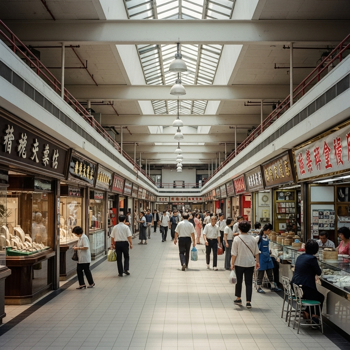

--- inside the function call response...
Function Name: display_image_file
Function Results ["Success"]
>>> inside final response...
Final Response (1987.01 ms):
I'm now displaying hongkong-mall-1.png.

-----------------------------
Total elapsed time: 1987.01


In [ ]:
events = call_agent('display hongkong-mall-2.png')
pprint_events(events)

+++ inside the function call...
function, [args]:  display_image_file, {'filename': 'hongkong-mall-0.png'}


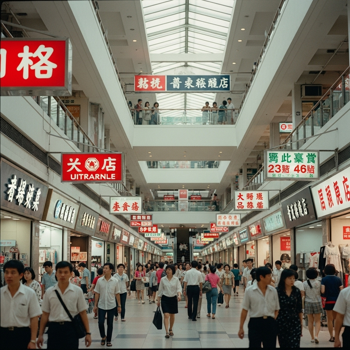

--- inside the function call response...
Function Name: display_image_file
Function Results ["Success"]


+++ inside the function call...
function, [args]:  display_image_file, {'filename': 'hongkong-mall-1.png'}


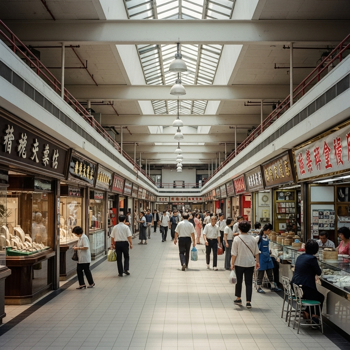

--- inside the function call response...
Function Name: display_image_file
Function Results ["Success"]


+++ inside the function call...
function, [args]:  display_image_file, {'filename': 'hongkong-mall-2.png'}


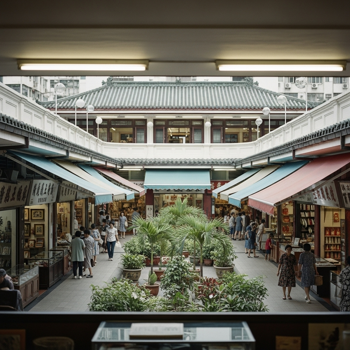

--- inside the function call response...
Function Name: display_image_file
Function Results ["Success"]


+++ inside the function call...
function, [args]:  display_image_file, {'filename': 'hongkong-mall-3.png'}


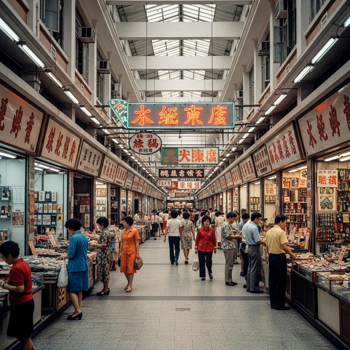

--- inside the function call response...
Function Name: display_image_file
Function Results ["Success"]
>>> inside final response...
Final Response (6166.014 ms):
I'm now displaying hongkong-mall-3.png. I have displayed all four images.

-----------------------------
Total elapsed time: 6166.014


In [ ]:
events = call_agent('display all images')
pprint_events(events)